Skin Disease Diagnosis using Image Processing


Data Processing

Import necessary libraries

In [49]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image, UnidentifiedImageError
import numpy as np
from scipy.spatial.distance import cosine
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import matplotlib.pyplot as plt
import random
import requests
from io import BytesIO



In [34]:
skin_disease_data = pd.read_csv('/content/drive/MyDrive/RA-MultiModel-ReducedSpecifciation/Dataset/skindisease.csv')

In [57]:
eda_data = skin_disease_data[['label','nine_partition_label','url']]

In [60]:
eda_data_filtered.isna().any().any()

False

In [58]:
eda_data_filtered=eda_data.dropna()

            label nine_partition_label  \
count       16536                16536   
unique        114                    9   
top     psoriasis         inflammatory   
freq          653                10851   

                                                      url  
count                                               16536  
unique                                              16536  
top     https://www.dermaamin.com/site/images/clinical...  
freq                                                    1  
inflammatory                    10851
malignant epidermal              1352
genodermatoses                   1194
benign dermal                    1067
benign epidermal                  931
malignant melanoma                570
benign melanocyte                 233
malignant cutaneous lymphoma      182
malignant dermal                  156
Name: nine_partition_label, dtype: int64


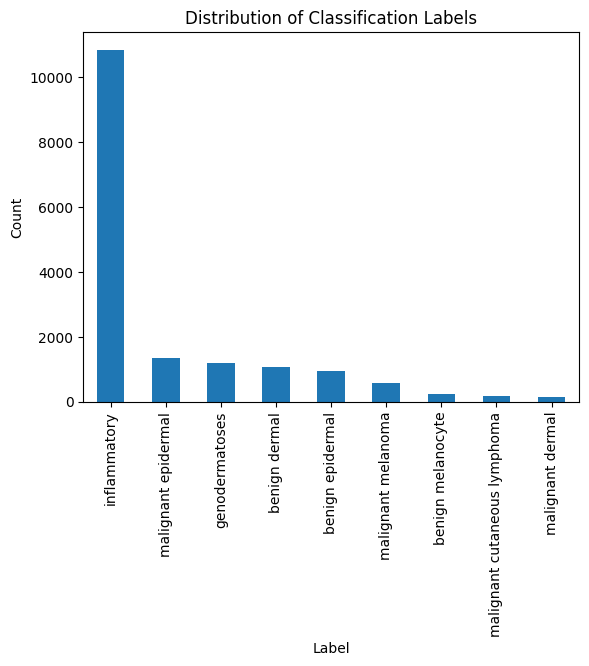

In [63]:
print(eda_data_filtered.describe())
print(eda_data_filtered['nine_partition_label'].value_counts())
eda_data_filtered['nine_partition_label'].value_counts().plot(kind='bar')
plt.title('Distribution of Classification Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [71]:
eda_data_filtered.to_csv('skin_disease_full.csv')

In [70]:

def plot_color_histogram(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Request Error: {e}")
        return
    except UnidentifiedImageError:
        print("Cannot identify image file.")
        return

    if img.mode == 'RGB':
        for channel, color in zip(range(3), ['Red', 'Green', 'Blue']):
            histogram = img.histogram()[channel*256:(channel+1)*256]
            plt.plot(histogram, color=color.lower())
    else:
        histogram = img.convert('L').histogram()
        plt.plot(histogram, color='black')

    plt.title('Color Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

for url in eda_data_filtered['url']:
  plot_color_histogram(url)


Output hidden; open in https://colab.research.google.com to view.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import numpy as np
from scipy.spatial.distance import cosine
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to preprocess and extract features from an image buffer
def preprocess_and_extract_features(image_buffer):
    image = Image.open(image_buffer).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs[0].detach().numpy()  # Convert to NumPy array for easier processing

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/RA-MultiModel-ReducedSpecifciation/Dataset/skin_disease_embeddings_full.csv')
dataset_texts = data['label'].tolist()  # Column name for descriptive text
dataset_embeddings = data.drop('label', axis=1).values  # Drop the label column to get embeddings

# Function to find the closest matches in the dataset
def find_closest_matches(patient_embedding, dataset_embeddings, top_n=5):
    similarities = [cosine(patient_embedding, emb) for emb in dataset_embeddings]
    closest_indices = np.argsort(similarities)[:top_n]
    return closest_indices

# Main function to process a patient's image and find matches
def diagnose_skin_condition(image_buffer):
    patient_embedding = preprocess_and_extract_features(image_buffer)
    closest_matches = find_closest_matches(patient_embedding, dataset_embeddings)
    matched_descriptions = [dataset_texts[idx] for idx in closest_matches]
    return matched_descriptions

upload_button = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False,
    description='Upload Image'
)

output = widgets.Output()

def on_upload_change(change):
    if not upload_button.value:
        return

    uploaded_file = next(iter(upload_button.value.values()))
    image_buffer = io.BytesIO(uploaded_file['content'])

    matched_descriptions = diagnose_skin_condition(image_buffer)

    with output:
        clear_output()
        display(Image.open(image_buffer))
        for description in matched_descriptions:
            print(f"Predicted Skin condition: {description}")

upload_button.observe(on_upload_change, names='value')

display(upload_button, output)


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload Image')

Output()